<a href="https://colab.research.google.com/github/shaunak09vb/Toxic-Comment-Classifier-using-LSTM/blob/main/NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import numpy as np, pandas as pd
from tqdm import tqdm_notebook

import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
nltk.download('wordnet')
import string
from string import ascii_lowercase

import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import io

from functools import reduce

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [64]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2   
embedding_dim = 200      

# Importing Data

In [4]:
train=pd.read_csv('https://raw.githubusercontent.com/shaunak09vb/Toxic-Comment-Classifier-using-LSTM/main/Data/train.csv')    

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
#test=pd.read_csv('https://raw.githubusercontent.com/shaunak09vb/Toxic-Comment-Classifier-using-LSTM/main/Data/test.csv')

In [7]:
#test.head()

# Data Exploration

Checking for missing values

In [8]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [9]:
#test.isnull().any()


In [54]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

#Data Pre-processing

## Text Normalization

* Removing Characters in between Text
* Removing Repeated Characters
* Converting data to lower-case
* Removing Numbers from the data
* Remove Punctuation
* Remove Whitespaces
* Removing spaces in between words
* Removing "\n"
* Remove Non-english characters

In [11]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [12]:
'''Abbreviation = {
    'a moderate amount of hate':
        [
        'amoah'
        ],
    'another day in hell':
        [
        'adih'
        ],
    'as fuck':
        [
        'af'
        ],
    'boyfriend':
        [
        'bf'
        ],
    'chicks':
        [
        'chx'
        ],
    'for your information':
        [
         'fyi'
        ],
    'get the fuck out':
        [
         'gtfo'
        ],
    'girlfriend':
        [
        'gf'
        ],
    'good morning':
        [
         'gm'
        ],
    'good night':
        [
         'gn'
        ],
    'hugs and kisses':
        [
         'hak','xoxo'
        ],
    'i dont care':
        [
         'idc'
        ],
    'i dont know':
        [
         'idk'
        ],
    'i hate you':
        [
         'ih8u'
        ],
    'i know':
        [
         'ik'
        ],
    'i know right':
        [
         'ikr'
        ],
    'i love you':
        [
         'ilu','ily'
        ],
    'i miss you':
        [
         'imy','imu'
        ],
    'in real life':
        [
         'irl'
        ],
    'in my opinion':
        [
         'imo'
        ],
    'just kidding':
        [
         'jk'
        ],
    'later':
        [
         'l8r'
        ],
    'laugh my ass off':
        [
         'lmao'
        ],
    'laugh out loud':
        [
         'lol'
        ],
    'love':
        [
         '<3','luv'
        ],
    'message':
        [
         'msg'
        ],
    'nevermind':
        [
         'nvm'
        ],
    'no problem':
        [
         'np'
        ],
    'oh my god':
        [
         'omg'
        ],
    'on the way':
        [
         'otw'
        ],
    'please':
        [
          'pls','plz'
        ],
    'rolling on the floor laughing':
        [
          'rofl', 'rotfl'
        ],
    'shut the fuck up':
        [
          'stfu'
        ],
    'talk to you later':
        [
          'ttyl'
        ],
    'thank you so much':
        [
          'tysm'
        ],
    'thanks':
        [
         'thnx','thnks','thx',
        ],
    'thank you':
        [
         'ty','tu'
        ],
    'tonight':
        [
         '2nyt','2nite'
        ],
    'to be announced':
        [
         'tba'
        ],
    'to be decided':
        [
         'tbd'
        ],
    'too much information':
        [
         'tmi'
        ],
    'you only live once':
        [
         'yolo'
        ],
    'your':
        [
         'ur'
        ],
    'what are you doing':
        [
         'wyd'
        ],
    'what the fuck':
        [
         'wtf'  
        ],
    'what the hell':
        [
         'wth'
        ],
    'without':
        [
         'w/o','wo' 
        ],
     'works for me':
        [
         'wfm'
        ],     

}'''

"Abbreviation = {\n    'a moderate amount of hate':\n        [\n        'amoah'\n        ],\n    'another day in hell':\n        [\n        'adih'\n        ],\n    'as fuck':\n        [\n        'af'\n        ],\n    'boyfriend':\n        [\n        'bf'\n        ],\n    'chicks':\n        [\n        'chx'\n        ],\n    'for your information':\n        [\n         'fyi'\n        ],\n    'get the fuck out':\n        [\n         'gtfo'\n        ],\n    'girlfriend':\n        [\n        'gf'\n        ],\n    'good morning':\n        [\n         'gm'\n        ],\n    'good night':\n        [\n         'gn'\n        ],\n    'hugs and kisses':\n        [\n         'hak','xoxo'\n        ],\n    'i dont care':\n        [\n         'idc'\n        ],\n    'i dont know':\n        [\n         'idk'\n        ],\n    'i hate you':\n        [\n         'ih8u'\n        ],\n    'i know':\n        [\n         'ik'\n        ],\n    'i know right':\n        [\n         'ikr'\n        ],\n    'i love yo

In [13]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True, remove_abbreviations=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 

Cleaning Training Data

In [14]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))

In [15]:
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

Cleaning Test Data

In [16]:
#test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))

In [17]:
#test['comment_text'][1048]

## Lemmatization

In [18]:
comments_train=train['comment_text']
#comments_test=test['comment_text']

In [19]:
comments_train=list(comments_train)
#comments_test=list(comments_test)

In [20]:
wordnet_lemmatizer = WordNetLemmatizer()

In [21]:
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 

Lemmatizing Training Data

In [22]:
lemmatized_train_data = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    lemmatized_train_data.append(lemma(line))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
lemmatized_train_data[152458]

'i agree with you about graemel s intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wp rr three revert rule notice board post by report the revert nazi graemel ha show himself herself to be a revert nazi this be unacceptable on a site that be make by it s user and not it s admins if you feel you have be unjustly revert more than time over a hour period please report him her to the three revert noticeboard wp rr it be time to take back what be ours'

Lemmatizing Test Data

In [24]:
#lemmatized_test_data = [] 

#for line in tqdm_notebook(processed_test_data, total=len(comments_test)): 
    #lemmatized_test_data.append(lemma(line))

## Stopwords Removal

In [25]:
stopword_list=STOP_WORDS
#stopword_list

Adding Single and Dual to STOP_WORDS

In [26]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [27]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [28]:
#dual_alpha_list

In [29]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


In [30]:
#stopword_list

Checking for other words that we may need in STOP_WORDS

In [31]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip())  

In [32]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
len(potential_stopwords)

159571

Combining all the sentences in the list into a single string

In [34]:
def string_combine_a(stopword):
  final_a=""
  for item in range(39893):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(39893,79785):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(79785,119678):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(119678,159571):
    final_d=final_d+" "+stopword[item]
  return final_d

In [35]:
total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

In [36]:
#total_string_potential_a

Counting the number of words in each of the 4 strings

In [37]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [38]:
#print(word_count(total_string_potential_a))
total_string_potential_a_dict=word_count(total_string_potential_a)
#print(word_count(total_string_potential_b))
total_string_potential_b_dict=word_count(total_string_potential_b)
#print(word_count(total_string_potential_c))
total_string_potential_c_dict=word_count(total_string_potential_c)
#print(word_count(total_string_potential_d))
total_string_potential_d_dict=word_count(total_string_potential_d)

Converting Dictionaries to Dataframe

In [39]:
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
#total_string_potential_a_df
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
#total_string_potential_b_df
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
#total_string_potential_c_df
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])
#total_string_potential_d_df

Getting Dataframe output in descending order

In [40]:
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

Looking for common terms in all top 50 dataframes

In [41]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))

In [42]:
print(common_potential_stopwords)

['write', 'new', 'point', 'thing', 'good', 'image', 'find', 'delete', 'user', 'reference', 'know', 'link', 'way', 'need', 'article', 'block', 'comment', 'section', 'fuck', 'wikipedia', 'time', 'people', 'talk', 'add', 'information', 'doe', 'read', 'like', 'use', 'change', 'thank', 'want', 'edit', 'remove', 'help', 'fact', 'don', 'list', 'source', 'editor', 'page', 'deletion', 'mean', 'question', 'work', 'look', 'think', 'try']


Retaining certain words and removing others form the above list

In [43]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

In [44]:
#potential_stopwords=['day','ask', 'consider', 'http', 'word', 'mean', 'try', 'let', 'feel', 'come', 'list', 'far', 'doe','thing','utc','note','mention' ]

Adding above retrived words into the stopwords list

In [45]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!


Removing Stopwords from Training Data

In [46]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())      

In [47]:
processed_train_data = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    processed_train_data.append(remove_stopwords(line))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
processed_train_data[152458]

'agree graemel intention revert nazi protect report revert rule notice board post report revert nazi graemel revert nazi unacceptable site admins feel unjustly revert hour period report revert noticeboard'

Removing Stopwords from Test Data

In [49]:
#processed_test_data = [] 

#for line in tqdm_notebook(comments_test, total=153164): 
    #processed_test_data.append(remove_stopwords(line))

# Model Building

Tokenization

In [50]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
#list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [51]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  148917


Padding

In [52]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
#X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [57]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  116   578    11 32199   239   192    11 32199   239    90    11   579
    11   116   366   578     1  1082   116   338  5356   116   119    11
   387   269   366   578    11     1  1341   116    11   387     2    32
   116   578   192   116   172    46    84   579   116   578    11     2
   488   105    10  1087   403  1073    11  2401   489    36   116    11
   192   407   366     9   255   192   242   150   109    18    19    29
   172    77    19     3   257  4540     4    11 32199   239   192    11
 32199   239    90   171   387   312    68   579    34    44    77   423
  1550    34   171     8   579  1268    77  1638   134    10   134  4671
   134    94    44   565  1255    17    77  1338   118   134  1577    77
  1134     4   507    77   434    31   171    68    34   168  2207   449
    31   315  1529    70   172   236   150   116    31    31    11    77
    31   116    11    77    31    77    31   192   171    46    84   579
     4    31   171   192    

Reason why the length was taken as 200 for maxpadlen

In [58]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train] 

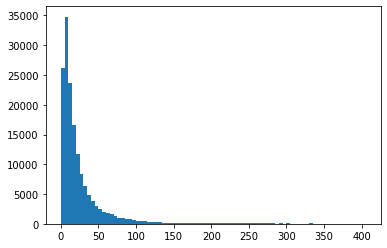

In [59]:
plt.hist(totalNumWords, bins=np.arange(0,410,5))
plt.show()

### Splitting data into Training and Validation Set

In [60]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)
X_t = X_t[indices]
labels = y[indices]

In [61]:
indices

array([ 84355,  57212,  84140, ...,   6247,  52493, 136783])

In [65]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [66]:
x_train.shape

(127657, 200)

In [67]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12292  1283  6810   374  6257  1123]
validation:  [3002  312 1639  104 1620  282]


### Importing Glove

In [68]:
embeddings_index = {}
f = open('/content/drive/MyDrive/Glove/glove.6B.200d.txt', encoding='utf8')
#print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

Done.
 Proceeding with Embedding Matrix...

In [69]:
embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

 Completed!


### Creating Model

In [70]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [71]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim,
                           weights = [embedding_matrix],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [72]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

In [73]:
model = Model(inputs=inp, outputs=preds)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [74]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 200)          29783600  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           62640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

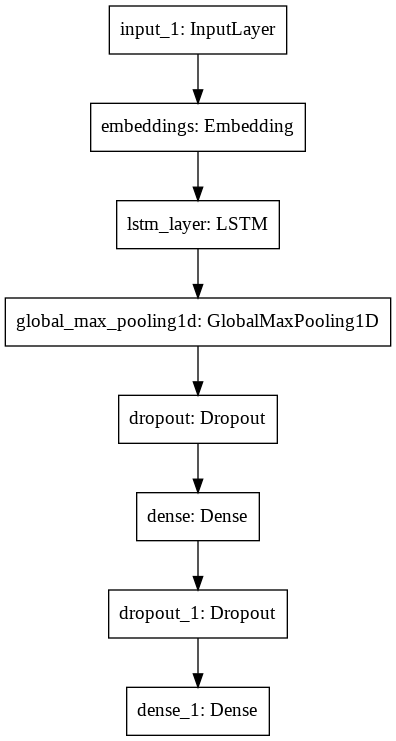

In [75]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

In [76]:
model_info=model.fit(x_train,y_train, epochs=2, batch_size=1,  validation_data=(x_val, y_val))

Epoch 1/2
127657/127657 [==============================] - 1079s 8ms/step - loss: 0.0682 - accuracy: 0.9518 - val_loss: 0.0595 - val_accuracy: 0.9935
Epoch 2/2
127657/127657 [==============================] - 1075s 8ms/step - loss: 0.0561 - accuracy: 0.9933 - val_loss: 0.0571 - val_accuracy: 0.9932


### Plotting Graphs

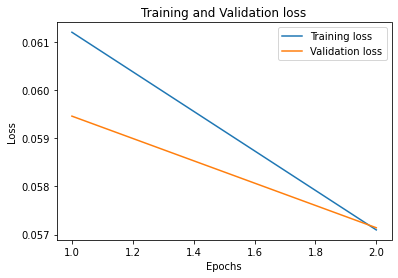

In [77]:
loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

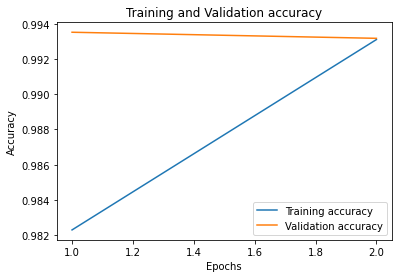

In [78]:
accuracy = model_info.history['accuracy']
val_accuracy = model_info.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();